In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
from scipy.optimize import minimize

import astropy.units as u

import pandas as pd
import exoplanet as xo

from astropy.io import fits
from astropy.table import Table

from flareTools import FINDflare, id_segments, EasyE
from flarePipeline import vetFlare

import matplotlib as mpl
mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

In [2]:
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec1to13/'

# Lots of flare detections towards the end
# Looks like the ones toward the beginning got missed
# This gets much better if we drop the CPA parameters to 3, 1, 3
f1 = 'tess2018206045859-s0001-0000000079403675-0120-s_lc.fits'

f2 = 'tess2019112060037-s0011-0000000121196226-0143-s_lc.fits'

f3 = 'tess2018206045859-s0001-0000000212262797-0120-s_lc.fits'

# Looks like a couple of strong flares are being missed?
# Its because I masked out this region of the LC
f4 = 'tess2018206045859-s0001-0000000266997586-0120-s_lc.fits'

# Lots of flares, why are some missed?
f5 = 'tess2018234235059-s0002-0000000102032397-0121-s_lc.fits'

Text(0, 0.5, 'Flux [e-/s]')

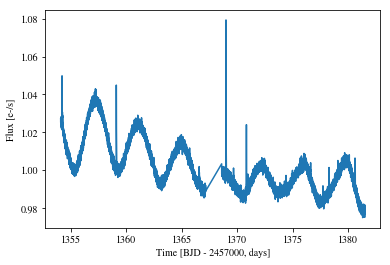

In [3]:
with fits.open(path+f5, mode='readonly') as hdulist:
    #print(hdulist[1].header)
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
    tess_quality = hdulist[1].data['QUALITY']
    
mask = (tess_quality == 0) & (~np.isnan(tess_bjds))

time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
median = np.nanmedian(flux)
error = pdcsap_flux_error[mask]

plt.plot(time, flux/median)
plt.xlabel('Time [BJD - 2457000, days]')
plt.ylabel('Flux [e-/s]')
#plt.xlim(1624.8,1628)

In [4]:
dt_limit = 12/24 # 12 hours
trim = 4/24 # 4 hours
istart, istop = id_segments(time, dt_limit, dt_trim=trim)

time_trim = np.array([])
flux_trim = np.array([])
error_trim = np.array([])

for seg_idx in range(len(istart)):
    print(time[istart[seg_idx]], time[istop[seg_idx]])
    time_seg = time[istart[seg_idx]:istop[seg_idx]]
    flux_seg = flux[istart[seg_idx]:istop[seg_idx]]
    error_seg = error[istart[seg_idx]:istop[seg_idx]]

    time_trim = np.concatenate((time_trim, time_seg), axis=0)
    flux_trim = np.concatenate((flux_trim, flux_seg), axis=0)
    error_trim = np.concatenate((error_trim, error_seg), axis=0)
    
time = time_trim
flux = flux_trim
error = error_trim
    
median = np.nanmedian(flux)

1354.2799655943804 1366.9898662369544
1368.7732132025806 1381.3495768099617


Text(0, 0.5, 'Flux [e-/s]')

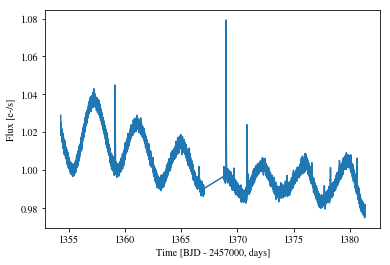

In [5]:
plt.plot(time, flux/median)
plt.xlabel('Time [BJD - 2457000, days]')
plt.ylabel('Flux [e-/s]')

In [6]:
acf = xo.autocorr_estimator(time, flux/median,
                        yerr=error/median,
                        min_period=0.1, max_period=27, max_peaks=2)

if len(acf['peaks']) > 0:
    acf_1dt = acf['peaks'][0]['period']
    mask = np.where((acf['autocorr'][0] == acf['peaks'][0]['period']))[0]
    acf_1pk = acf['autocorr'][1][mask][0]
    s_window = int(acf_1dt/np.fabs(np.nanmedian(np.diff(time))) / 6)
else:
    acf_1dt = (time[-1] - time[0])/2
    s_window = 128

In [7]:
acf_1dt

3.64024881353771

/astro/users/scw7/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


17831 17459
17459 17394
17394 17442
17442 17442


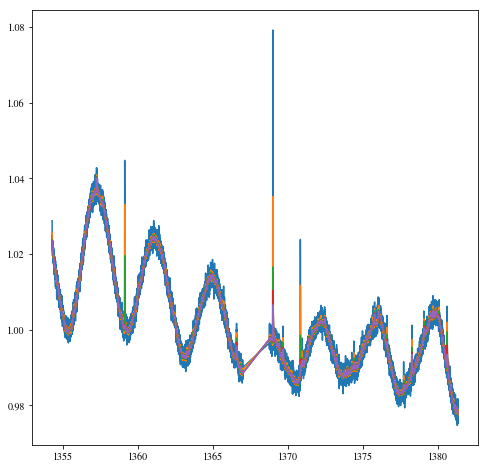

In [8]:
num_iter = 20

x = time
y = flux/median
yerr = error/median

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-20, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter('log_Q')

# A periodic component
Q = 1.0
w0 = 2*np.pi/acf_1dt
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

# Now calculate the covariance matrix using the initial
# kernel parameters
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(x, yerr)

def neg_log_like(params, y, gp, m):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y[m])

def grad_neg_log_like(params, y, gp,m ):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y[m])[1]

bounds = gp.get_parameter_bounds()
initial_params = gp.get_parameter_vector()

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(x, y)

# Find the best fit kernel parameters. We want to try to ignore the flares
# when we do the fit. To do this, we will repeatedly find the best fit
# solution to the kernel model, calculate the covariance matrix, predict
# the flux and then mask out points based on how far they deviate from
# the model. After a few passes, this should cause the model to fit mostly
# to periodic features.
m = np.ones(len(x), dtype=bool)
for i in range(num_iter):
    gp.compute(x[m], yerr[m])
    soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                    method='L-BFGS-B', bounds=bounds, args=(y, gp, m))
    gp.set_parameter_vector(soln.x)
    initial_params = soln.x
    mu = gp.predict(y[m], x, return_cov=False, return_var=False)
    axes.plot(x, mu)
    #axes.set_xlim(1427,1428)
    var = np.nanvar(y - mu)
    sig = np.sqrt(var + yerr**2)

    m0 = y - mu < 1.3 * sig
    n_pts_prev = np.sum(m)
    n_pts = np.sum(m0)
    print(n_pts_prev, n_pts)
    if n_pts == 0:
        print('Warning: all points thrown out (noisy LC?)')
        break
    m = m0
    if (n_pts == n_pts_prev): #or np.fabs(n_pts - n_pts_prev) < 3:
        break

gp.compute(x[m], yerr[m])
mu = gp.predict(y[m], time, return_cov=False, return_var=False)

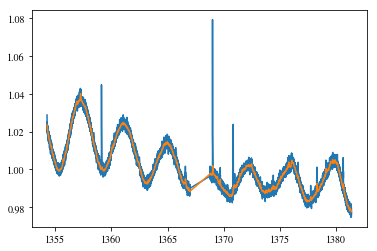

In [9]:
plt.plot(time, flux/median)
plt.plot(time, mu)

In [12]:
# Search for flares in the smoothed light curve using change point analysis
FL = FINDflare(flux/median - mu, error/median,
               avg_std=True, std_window=s_window, N1=3, N2=1, N3=3)

1359.118943288805 1359.1508882255362 6.246869009700778 6.7204618571292
1359.1223353543683 0.006886508646061093
[56.05339387  8.29205641] s
1366.574584989364 1366.5843072932546 1.2691691192702403 1.136009616880102
1366.5766118360716 0.01032152069490447
[ 7.05139151 12.63465047] s
1368.9940478389458 1369.0287702573137 1.9311604654611894 23.478219037740935
1368.9968126674887 0.00435478779513438
[48.46790575  4.98540531] s
1370.8343332510944 1370.8496110714595 4.757521045228277 4.653506918470538
1370.8365691825477 0.004618301395090786
[24.28693354  5.4639739 ] s
1376.613495628461 1376.6190511614677 1.1690907273133233 0.6241039278878697
1376.6152299472772 0.008069918360269766
[4.43632049 9.56954274] s
1380.610693659602 1380.6315268329972 2.1381282987307153 2.837655769386854
1380.6143567181032 0.0116561091383261
[22.11832836 14.65787873] s
1380.632915711301 1380.6370823459806 7.938989345624154 1.1666343186072117
1380.634910998957 0.002083317982671947
[6.90350692 2.32759681] s


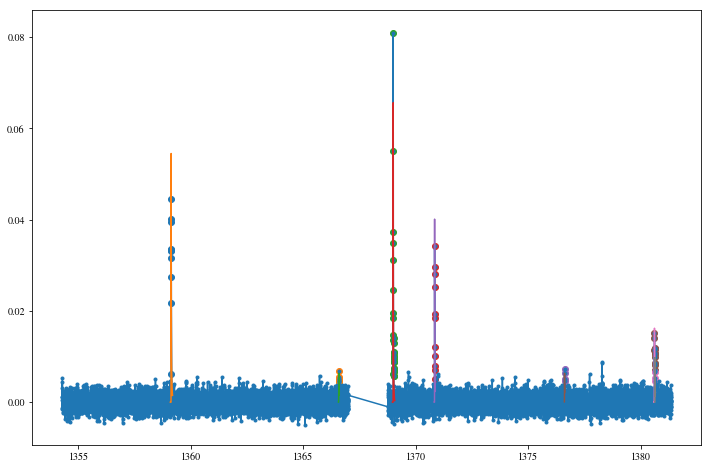

In [13]:
from flareTools import aflare1
from flarePipeline import measure_ED
fig, axes = plt.subplots(figsize=(12,8))
axes.plot(time, flux/median-mu, marker='o', markersize=3)
for j in range(len(FL[0])):
    s1, s2 = FL[0][j], FL[1][j]+1
    axes.scatter(time[s1:s2], flux[s1:s2]/median-mu[s1:s2])#, color='r')
    
    tstart, tstop = time[s1], time[s2]
    dx_fac = 2
    popt1, pstd1, g_chisq, popt2, pstd2, f_chisq = vetFlare(time, flux/median-mu,\
                                                            error/median, tstart, tstop, \
                                                            dx_fac=dx_fac)
    
    dx = tstop - tstart
    x1 = tstart - dx*dx_fac/2
    x2 = tstop + dx*dx_fac/2
    
    xmodel = np.linspace(x1, x2)
    ymodel = aflare1(xmodel, popt2[0], popt2[1], popt2[2])
    plt.plot(xmodel, ymodel)
    print(tstart, tstop, f_chisq, g_chisq)
    
    ed = measure_ED(time, flux/median-mu, error/median, popt2[0], popt2[1])
    print(popt2[0], popt2[1])
    print((ed*u.d).to(u.s))
    
#plt.xlim(1359,1359.25)

In [41]:
# Get the GP variance around the flare detection
mask = (time > 1348.5) & (time < 1349.5)
mu1, var = gp.predict(y[m], time[mask], return_var=True)

1359.118943288805 1359.1508882255362 6.246869009700778 6.7204618571292
1368.9940478389458 1369.0287702573137 1.9311604654611894 23.478219037740935
1370.8343332510944 1370.848222178721 5.22789405255184 4.998053980214043
1380.610693659602 1380.6315268329972 2.1381282987307153 2.837655769386854


(1349, 1349.1)

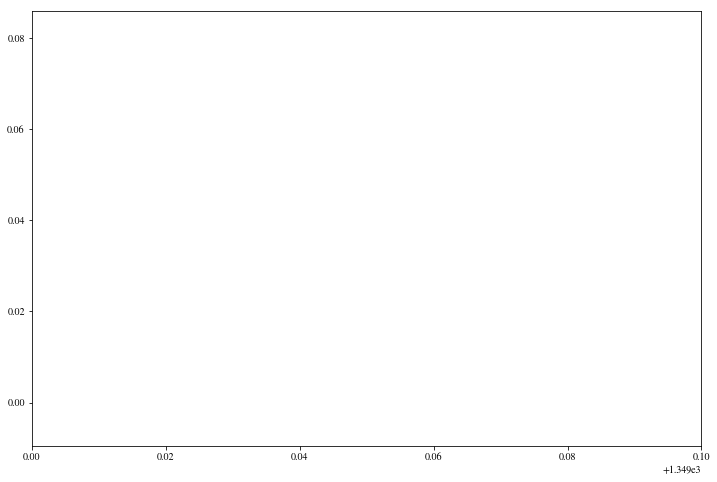

In [42]:
fig, axes = plt.subplots(figsize=(12,8))

axes.plot(time[mask], flux[mask]/median-mu1)
std = np.sqrt(var + yerr[mask]**2)
axes.fill_between(time[mask], -std*3, std*3, alpha=0.3)

axes.plot(time, flux/median-mu, marker='o', markersize=3)
for j in range(len(FL[0])):
    s1, s2 = FL[0][j], FL[1][j]+1
    axes.scatter(time[s1:s2], flux[s1:s2]/median-mu[s1:s2], s=50)#, color='r')
    
    tstart, tstop = time[s1], time[s2]
    popt1, pstd1, g_chisq, popt2, pstd2, f_chisq = vetFlare(time, flux/median-mu, error/median, tstart, tstop, dx_fac=2)
    print(tstart, tstop, f_chisq, g_chisq)
plt.xlim(1349,1349.1)